An autoencoder Consists of 3 parts:
    1. Encoder
    2. Bottleneck
    3. Decoder
    
Encoder/Decoder are fully connected feed foward neural networks
and the bottleneck is 
    

In [1]:
import os
import time
import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import datasets


#torch.set_default_tensor_type('torch.cuda.FloatTensor')
tensor_transform = transforms.ToTensor()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


In [2]:
# %% train data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=0
)

example_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=0,drop_last=True,
    )




In [ ]:
flower_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Resize((300,300))
    ])

flowers_train_dataset = torchvision.datasets.Flowers102(
    root="~/torch_datasets",split="train",transform=flower_transform,download=True)

flower_loader = torch.utils.data.DataLoader(
    flowers_train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True
)





In [3]:
#Helper functions
def plot():
    f, axarr = plt.subplots(2)

    for i, item in enumerate(image):
    # Reshape the array for plotting
        item = item.reshape(-1, 28, 28)
        axarr[0].imshow(item[0].cpu())

    for i, item in enumerate(reconstructed):
        item = item.reshape(-1, 28, 28).cpu()
        item = item.detach().numpy()
        axarr[1].imshow(item[0])
        
        
        
def showExample():
    for image, _ in example_loader:
        f, axarr = plt.subplots(2)
        image = image.reshape(-1,28*28).to(device)

        model.to(device)
        recon = model(image)

        image = image.reshape(-1, 28, 28)
        axarr[0].imshow(image[0].cpu())


        recon = recon.reshape(-1, 28, 28).to('cpu')
        axarr[1].imshow(recon[0].detach().numpy())

        break

def add_noise(inputs,variance):
    noise = torch.randn_like(inputs)
    return inputs + variance*noise

        
        
        
        

pin_memory = true allowsto speed up training when we load to cpu then push to gpu 
(Lets you allocate sampl es in page-locked memory, should be enabled when training on gpu )

In [ ]:
#datasets.MNIST()
from torchvision import datasets 

dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)


 
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=12,
                                     shuffle= True,
                                     generator=torch.Generator(device=device))




First we will be constructing the encoder and decoder, 2 fully connected, feed forward Neural networks  

Encoder will gradually reduce dimentionality  
28*28=784 -> 128 -> 64 -> 36 -> 18 -> 9
  
Decoder will do the opposite


In [4]:
input_size = 28*28  #784
hidden_size = 128
code_size = 32


class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Encoder 
        self.encoder = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,code_size)
        )
        
        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(code_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        self.model = nn.Sequential(
        
        )
        
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
        
        

In [5]:

# Model Initialization
model = autoencoder()
model.to(device)
 
# Validation using MSE Loss function
loss_function = nn.MSELoss()

#Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



### Train model for 20 epoch:
Things to notice:
- Firstly we are setting to zero gradient before each backpropagation
    because pytorch accumulates the gradients on subsequent backward losses
    (this may be usefull when training RNNs)
- then we are passing the image through the model and calculate loss with a simple MSE Loss$$ (x - g(f(x)))^{2} $$

- loss.backward() computes loss and we are preforming backpropagation with optimizer.step()


In [6]:
epochs = 20
losses = 0

for epoch in range(epochs):
    for image, _ in train_loader:
        image = image.reshape(-1,28*28).to(device)
        noised_image = add_noise(image,0.2)
        #set gradients to zero
        
        reconstructed = model(noised_image)
        loss = loss_function(reconstructed , noised_image)
        
        optimizer.zero_grad()
        loss.backward() # Preforms Backpropagation and calculates  gradients 
        optimizer.step() # Updates Weights based on the gradients computed above
        losses += loss.item()
    losses = losses / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

        

epoch : 1/20, loss = 0.074463
epoch : 2/20, loss = 0.061052
epoch : 3/20, loss = 0.058871
epoch : 4/20, loss = 0.054600
epoch : 5/20, loss = 0.051979
epoch : 6/20, loss = 0.051799
epoch : 7/20, loss = 0.052511
epoch : 8/20, loss = 0.050143
epoch : 9/20, loss = 0.050615
epoch : 10/20, loss = 0.049671
epoch : 11/20, loss = 0.049430
epoch : 12/20, loss = 0.048494
epoch : 13/20, loss = 0.048781
epoch : 14/20, loss = 0.048546
epoch : 15/20, loss = 0.049482
epoch : 16/20, loss = 0.048745
epoch : 17/20, loss = 0.047823
epoch : 18/20, loss = 0.048055
epoch : 19/20, loss = 0.047880
epoch : 20/20, loss = 0.047976


In [ ]:
showExample()

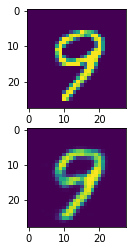

In [17]:


for image, _ in train_loader:
    #example = torch.movedim(image[0],(1,2),(0,1))
   
    f, axarr = plt.subplots(2)
    image = image.reshape(-1,28*28).to(device)
    
    image = add_noise(image,0.0)
    model.to(device)
    recon = model(image)
    image = image.reshape(-1, 28, 28)
   
    axarr[0].imshow(image[0].cpu())
    

    
    recon = recon.reshape(-1, 28, 28).to('cpu')
    #example = torch.movedim(example,(0,1,2),(-1,-2,-3))
    axarr[1].imshow(recon[0].detach().numpy())

    break    
    
    
    